<a href="https://colab.research.google.com/github/DhruvDarda/Persuasive-Text-Generation-in-Fashion/blob/main/Persuasive_NLP_Seq2Seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Persuasive text often includes:

repeated words,

alliterative words,

emotional language,

a strong argument,

rhetorical questions,

colourful and eye-catching fonts / capitalised words,

humour

Words with high modality, that is, words that show a high degree of certainty. For example – must, ought to, shall, has to. In comparison to words such as may, might, could and would that have low modality and show less certainty

Emotive, descriptive words that appeal to the emotions. For example – wonderful, horrible, cruel, amazing, frightening, perfect

A formal voice that is more authoritative and has more power of persuasion

Repetition of words or phrases and concepts to push your point of view

Connectives that help sequence your argument. For example – Firstly, Secondly

Present tense

In [ ]:
import re
import os
import pickle
import random
from torch.autograd import Variable
import numpy as np
import pandas as pd
import torch
import torch.optim
import torch.nn as nn
from torch import Tensor 
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
from torch.utils.tensorboard import SummaryWriter
drive.mount('/content/gdrive/')

%cd /content/gdrive/My Drive/'NLP PROJECT'
writer = SummaryWriter('Transformer/seq2seq')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
/content/gdrive/My Drive/NLP PROJECT


In [ ]:
%ls

Ethnic_Wear_Data.csv   my_checkpoint.pth.tar     runs/       Transformer/
Ethnic_wear_final.csv  my_checkpointseq.pth.tar  test.csv    tut1-model.pt
inputs_final1.txt      outputs_final.txt         test.json
inputs_large.txt       outputs_large.txt         train.csv
inputs.txt             outputs.txt               train.json


In [ ]:
inputs = open('inputs_large.txt').read().split('\n')
outputs = open('outputs_large.txt').read().split('\n')
inputs = inputs[:min(len(inputs), len(outputs))]
outputs = outputs[:min(len(inputs), len(outputs))]

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

###First Implementation

In [ ]:
raw_data = {'inputs':[line for line in inputs],
            'outputs': [line for line in outputs]}
df = pd.DataFrame(raw_data, columns = ['inputs', 'outputs'])
print(df.head())

train, test = train_test_split(df, test_size = 0.2)

train.to_json('train.json', orient='records', lines = True)
test.to_json('test.json', orient='records', lines = True)

                                              inputs                                            outputs
0  Women Navy Blue & amp ; Rust Orange Printed St...  This fashionable kurta from anayna will take y...
1  Green & amp ; Gold - Toned Silk Blend Embroide...  This fashionable kurta from anayna will take y...
2  Women Green & amp ; Pink Embroidered Straight ...  Comfortable and stylish, this kurta from Vbuyz...
3  Dusty Pink Embroidered Semi - Stitched Lehenga...  Comfortable and stylish, this kurta from Vbuyz...
4  Women Pink Ethnic Motifs Yoke Design Regular G...  Comfortable and stylish, this kurta from Vbuyz...


In [ ]:
#!pip install -U torchtext==0.8.0
import spacy
from sklearn.model_selection import train_test_split
from torchtext.legacy.data import Field, BucketIterator, TabularDataset

In [ ]:
eng = spacy.load('en')
def tokenize_text(text):
  return [tok.text for tok in eng.tokenizer(text)]

In [ ]:
inp_fields = Field(use_vocab = True, tokenize = tokenize_text, lower = False, fix_length=100, init_token="<sos>", eos_token="<eos>")
out_fields = Field(use_vocab = True, tokenize = tokenize_text, lower = False, fix_length=100, init_token="<sos>", eos_token="<eos>")

In [ ]:
train_data, test_data = TabularDataset.splits(path='', train = 'train.json', test = 'test.json', format='json', fields = {'inputs':('text', inp_fields), 'outputs':('label', out_fields)})

In [ ]:
inp_fields.build_vocab(train_data, max_size = df.size, min_freq = 2)
out_fields.build_vocab(test_data, max_size = df.size, min_freq = 2)

In [ ]:
train_itr, test_itr = BucketIterator.splits((train_data, test_data), batch_size=32, device = device, sort_key = lambda x: len(x.text),
    sort_within_batch=True)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
class ModelParam(object):
    def __init__(self, param_dict: dict = dict()):
        self.input_size = param_dict.get('input_size', 0)
        self.vocab_size = param_dict.get('vocab_size')
        self.embedding_dim = param_dict.get('embedding_dim', 300)
        self.target_dim = param_dict.get('target_dim', 2)
        
class MyModel(nn.Module):
    def __init__(self, model_param: ModelParam):
        super().__init__()
        self.embedding = nn.Embedding(
            model_param.vocab_size, 
            model_param.embedding_dim
        )
        self.lin = nn.LSTM(
            model_param.input_size * model_param.embedding_dim, 
            model_param.target_dim
        )
        
    def forward(self, x):
        features = self.embedding(x).view(x.size()[0], -1)
        features = F.relu(features)
        features = self.lin(features)
        return features

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        #print(src.shape)
        
        embedded = self.dropout(self.embedding(src))

        #print(embedded.shape)
        
        #embedded = embedded.reshape(1, embedded.shape[0], embedded.shape[1])
        
        #print(embedded.unsqueeze(-1).shape)
        #embedded = [src len, batch size, emb dim]
        
        outputs, (hidden, cell) = self.rnn(embedded)
        
        #outputs = [src len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden, cell

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
                
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #seq len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        prediction = self.fc_out(output.squeeze(0))
        #print(prediction)
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
        
        return outputs

In [ ]:
INPUT_DIM = len(inp_fields.vocab)
OUTPUT_DIM = len(out_fields.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 5
ENC_DROPOUT = 0.3
DEC_DROPOUT = 0.3

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

#print(dec)

model = Seq2Seq(enc, dec, device).to(device)

In [ ]:

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(3366, 256)
    (rnn): LSTM(256, 512, num_layers=5, dropout=0.3)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(1245, 256)
    (rnn): LSTM(256, 512, num_layers=5, dropout=0.3)
    (fc_out): Linear(in_features=512, out_features=1245, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 21,783,005 trainable parameters


In [ ]:
optimizer = torch.optim.Adam(model.parameters())
TRG_PAD_IDX = inp_fields.vocab.stoi[inp_fields.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [ ]:
def train(epoch, model, iterator, optimizer, criterion, clip):
    #epoch, model, optimizer = load_checkpoint(PATH, model, optimizer)

    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.text.to(device)
        #print(src.shape)
        
        trg = batch.label.to(device)
        #print(trg.shape)
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        #print(output, trg)
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
    
    checkpoint = {"state_dict" : model.state_dict(), "optimizer" : optimizer.state_dict(), 'epoch' : epoch}
    save_checkpoint(checkpoint)
        
    return epoch_loss / len(iterator)

In [ ]:
def batchify(data: Tensor, bsz: int) -> Tensor:
    """Divides the data into bsz separate sequences, removing extra elements
    that wouldn't cleanly fit.

    Args:
        data: Tensor, shape [N]
        bsz: int, batch size

    Returns:
        Tensor of shape [N // bsz, bsz]
    """
    seq_len = data.size(0) // bsz
    data = data[:seq_len * bsz]
    data = data.view(bsz, seq_len).t().contiguous()
    return data.to(device)

In [ ]:
bptt = 35
from typing import Tuple
def get_batch(source: Tensor, i: int) -> Tuple[Tensor, Tensor]:
    """
    Args:
        source: Tensor, shape [full_seq_len, batch_size]
        i: int

    Returns:
        tuple (data, target), where data has shape [seq_len, batch_size] and
        target has shape [seq_len * batch_size]
    """
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].reshape(-1)
    return data, target

In [ ]:
def Persuasive_sentence(model, sentence, input, per_out, device, max_length=50):

    # Create tokens using spacy and everything in lower case (which is what our vocab is)
    if type(sentence) == str:
        tokens = [token.text for token in eng(sentence)]
    else:
        tokens = [token for token in sentence]

    # Add <SOS> and <EOS> in beginning and end respectively
    tokens.insert(0, input.init_token)
    tokens.append(input.eos_token)

    # Go through each german token and convert to an index
    text_to_indices = [input.vocab.stoi[token] for token in tokens]

    # Convert to Tensor
    sentence_tensor = torch.LongTensor(text_to_indices).to(device).reshape(1,-1).t()
    print(sentence_tensor.shape) #->67
    #sentence_tensor = batchify(sentence_tensor, 67)
    #print(sentence_tensor.shape)
    

    outputs = [per_out.vocab.stoi["<sos>"]]
    for i in range(max_length):
        trg_tensor = torch.LongTensor(outputs).unsqueeze(1).to(device)
        print(trg_tensor.shape)
        #data, targ = get_batch(sentence_tensor, 0)
        #print(data.shape, targ.shape)

        with torch.no_grad():
            output = model(sentence_tensor, trg_tensor)
            #output = model(data, targ)

        best_guess = output.argmax(2)[-1, :].item()
        outputs.append(best_guess)

        if best_guess == per_out.vocab.stoi["<eos>"]:
            break

    translated_sentence = [per_out.vocab.itos[idx] for idx in outputs]
    # remove start token
    return translated_sentence[1:]

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.text.to(device)
            trg = batch.label.to(device)

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]
            #print(output)

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
path = %pwd
PATH = os.path.join(path, 'my_checkpointseq.pth.tar')

def save_checkpoint(state, filename="my_checkpointseq.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(PATH, model, optimizer):
    print("=> Loading checkpoint")
    checkpoint = torch.load(PATH)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    epoch = checkpoint['epoch']
    return epoch, model, optimizer

In [ ]:
import time
import math 

N_EPOCHS = 15
CLIP = 1

test_loss_l = []

best_valid_loss = float('inf')

sepoch = 0

#sepoch, model, optimizer = load_checkpoint(PATH, model, optimizer)

for epoch in range(sepoch, N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(epoch, model, train_itr, optimizer, criterion, CLIP)
    writer.add_scalar("Training loss", train_loss, global_step=epoch)
    valid_loss = evaluate(model, test_itr, criterion)
    writer.add_scalar("Validation loss", valid_loss, global_step=epoch)
    test_loss_l.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

=> Saving checkpoint
Epoch: 01 | Time: 5m 41s
	Train Loss: 4.619 | Train PPL: 101.376
	 Val. Loss: 4.481 |  Val. PPL:  88.351
=> Saving checkpoint
Epoch: 02 | Time: 5m 39s
	Train Loss: 4.225 | Train PPL:  68.374
	 Val. Loss: 4.539 |  Val. PPL:  93.554
=> Saving checkpoint
Epoch: 03 | Time: 5m 39s
	Train Loss: 3.789 | Train PPL:  44.193
	 Val. Loss: 5.421 |  Val. PPL: 226.101
=> Saving checkpoint
Epoch: 04 | Time: 5m 39s
	Train Loss: 3.045 | Train PPL:  21.018
	 Val. Loss: 6.462 |  Val. PPL: 640.267
=> Saving checkpoint
Epoch: 05 | Time: 5m 39s
	Train Loss: 2.475 | Train PPL:  11.886
	 Val. Loss: 7.415 |  Val. PPL: 1661.349
=> Saving checkpoint
Epoch: 06 | Time: 5m 38s
	Train Loss: 2.140 | Train PPL:   8.503
	 Val. Loss: 6.971 |  Val. PPL: 1065.267
=> Saving checkpoint
Epoch: 07 | Time: 5m 38s
	Train Loss: 1.925 | Train PPL:   6.855
	 Val. Loss: 8.144 |  Val. PPL: 3441.632
=> Saving checkpoint
Epoch: 08 | Time: 5m 38s
	Train Loss: 1.785 | Train PPL:   5.962
	 Val. Loss: 8.439 |  Val. PP

In [ ]:
model.load_state_dict(torch.load('tut1-model.pt'))

test_loss = evaluate(model, test_itr, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 4.481 | Test PPL:  88.351 |


Text(0.5, 0, '')

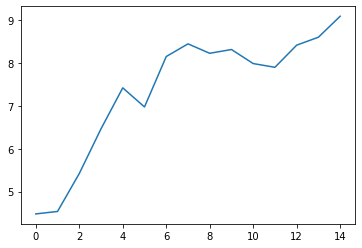

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(N_EPOCHS), test_loss_l)
plt.xlabel('')

In [ ]:
def bleu(data, model, german, english, device):
    targets = []
    outputs = []

    for example in data:
        src = vars(example)["text"]
        trg = vars(example)["label"]

        prediction = Persuasive_sentence(model, src, german, english, device)
        prediction = prediction[:-1]  # remove <eos> token

        targets.append([trg])
        outputs.append(prediction)

    return bleu_score(outputs, targets)

In [ ]:
model.eval()
print(inputs[3])
print(Persuasive_sentence(model, inputs[3], inp_fields, out_fields, device, max_length=50))

Dusty Pink Embroidered Semi - Stitched Lehenga & amp ; Unstitched Blouse With Dupatta SHUBHKALA Dusty pink embroidered lehenga choli with dupatta Dusty pink embroidered unstitched blouse with beaded detail Dusty pink embroidered semi - stitched lehenga with beaded detail , has drawstring and concealed zip closure , flared hem , and an attached lining Dusty pink embroidered dupatta Material : Viscose Rayon Dry Clean
torch.Size([67, 1])
torch.Size([1, 1])
torch.Size([2, 1])
torch.Size([3, 1])
torch.Size([4, 1])
torch.Size([5, 1])
torch.Size([6, 1])
torch.Size([7, 1])
torch.Size([8, 1])
torch.Size([9, 1])
torch.Size([10, 1])
torch.Size([11, 1])
torch.Size([12, 1])
torch.Size([13, 1])
torch.Size([14, 1])
torch.Size([15, 1])
torch.Size([16, 1])
torch.Size([17, 1])
torch.Size([18, 1])
torch.Size([19, 1])
torch.Size([20, 1])
torch.Size([21, 1])
torch.Size([22, 1])
torch.Size([23, 1])
torch.Size([24, 1])
torch.Size([25, 1])
torch.Size([26, 1])
torch.Size([27, 1])
torch.Size([28, 1])
torch.Size

In [ ]:
score = bleu(test_data[1:100], model, inp_fields, out_fields, device)
print(f"Bleu score {score*100:.2f}")